# 3D Deformation Tests

Multiple attempts at defining an augmentation function which accepts an image and a mask and produces a deformed image/mask pair. There's numerous ways of doing this but some are much faster than others or produce nicer output. Extending the notions of the 2D set of tests to 3D isn't always efficient or possible. We would want an algorithm that's fast enough to apply during training but if not then we will have to resort to pre-generating data before training which can be done with multiprocessing for speed.

105 ns ± 0.468 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


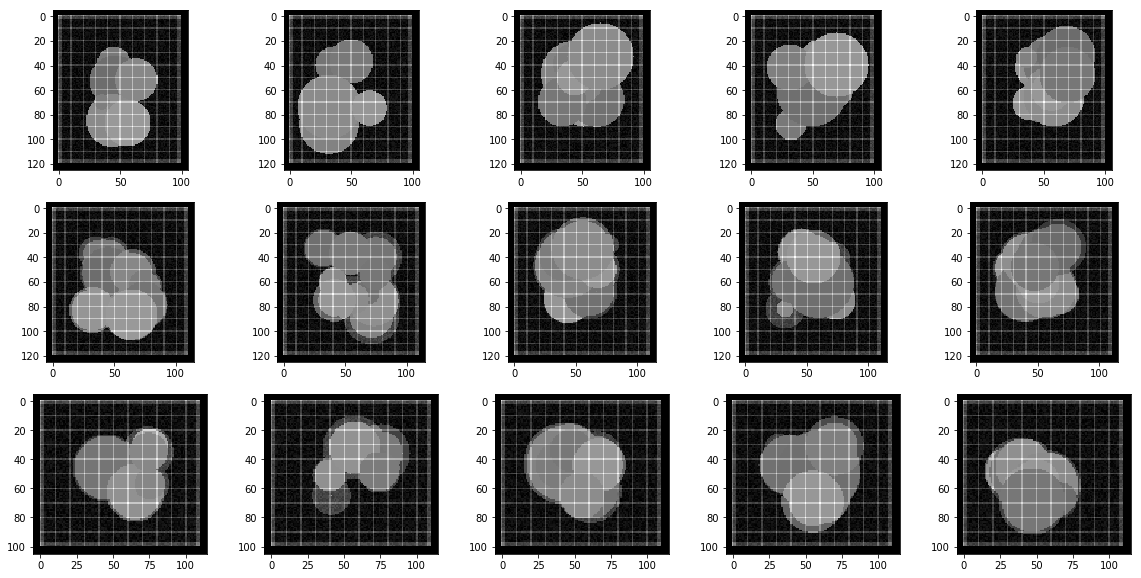

In [1]:
%matplotlib inline
from __future__ import print_function,division
import os, sys, datetime, glob, time
from collections import OrderedDict
from functools import partial
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation']='none'

imwidth = 100
imheight = 120
imdepth=110
numimgs = 5

def createTestImage(height, width, depth, numObjs=12, radMax=30):
    '''Return a noisy 3D image with `num_objs' circles and a 3D mask image.'''
    image = np.zeros((height, width, depth))

    for i in range(numObjs):
        y = np.random.randint(radMax, height - radMax)
        x = np.random.randint(radMax, width - radMax)
        z = np.random.randint(radMax, depth - radMax)
        rad = np.random.randint(10, radMax)
        
        spy, spx, spz = np.ogrid[-y:height-y,-x:width-x, -z:depth-z]
        sphere = (spx**2 + spy**2 + spz**2) <= rad**2
        image[sphere] = np.random.random() * 0.5 + 0.5

    norm = np.random.uniform(0, 0.25, size=image.shape)

    return np.maximum(image, norm), (image > 0).astype(np.int32) 


imagemaskpairs=[createTestImage(imheight,imwidth,imdepth) for _ in range(numimgs)]
    
    
def testAugment(aug):
    '''Time the augmentation function `aug' and draw its results in XY, XZ, and YZ planes with grid lines.'''
    
    %timeit aug(*imagemaskpairs[0])
    fig,ax=plt.subplots(3,numimgs,figsize=(20,10))

    for i in range(numimgs):
        def axshow(ind,im):
            ax[ind,i].axis('on')
            ax[ind,i].imshow(im)
            ax[ind,i].axis((-5, im.shape[1]+5, im.shape[0]+5, -5))
            ax[ind,i].set_facecolor('black')
            
        img,mask=imagemaskpairs[i]
        img=img.copy()
        
        # draw grid
        img[::10,:,:]+=0.5
        img[:,::10,:]+=0.5
        img[:,:,::10]+=0.5

        # draw border
        img[:,:, :3]+=0.5
        img[:,:,-3:]+=0.5
        img[:, :3,:]+=0.5
        img[:,-3:,:]+=0.5
        img[ :3,:,:]+=0.5
        img[-3:,:,:]+=0.5
        
        img,mask=aug(img,mask)

        axshow(0,img[:,:,imdepth//2]+mask[:,:,imdepth//2]*0.5)
        axshow(1,img[:,imdepth//2,:]+mask[:,imwidth//2,:]*0.5)
        axshow(2,img[imdepth//2,:,:]+mask[imheight//2,:,:]*0.5)
        
        
testAugment(lambda i,m:(i,m)) # test run with a null-deformation

952 ms ± 67.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


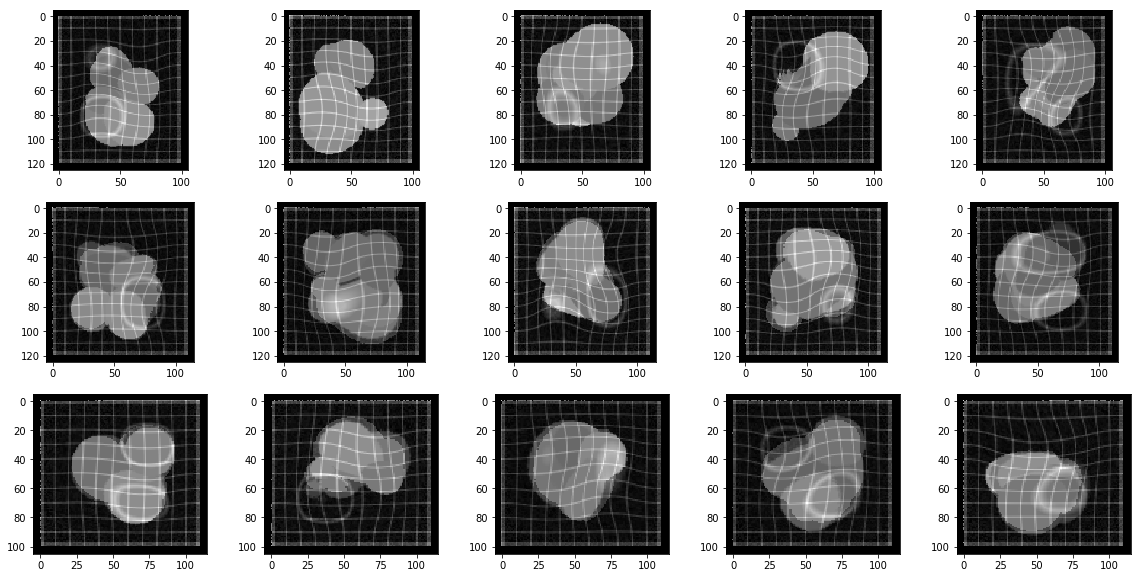

In [2]:
from scipy.ndimage.interpolation import map_coordinates,zoom


def deformBothAugment3D(image,mask,defrange=10,numControls=2,margin=1,zoomOrder=2,mapOrder=1):
    '''
    Deforms the `image' and `mask' input 3D volumes by defining a deformation cube of edge length numControls+margin*2 then resizing this to
    the size of the input images using zoom() to create a deformation gradient for each dimension. This implies that each dimension will be
    deformed by field defined by numControls**3 random values stretched to the size of the input using an interpolation of order `zoomOrder'.
    Using a high order interpolation ensures the field is smooth, a larger value for `numControls' will add more local variation. This is
    a slow algorithm because zoom() is not all that fast and map_coordinates() is called twice to map the original image pixels to their
    deformed coordinates.
    '''
    inshape=image.shape
    h,w,d = inshape
    ctrls=numControls+margin*2
    
    shift=np.zeros((ctrls,ctrls,ctrls)) # start by defining a small 3D volume for deformation values
    rshift=shift[margin:-margin,margin:-margin,margin:-margin] # get the inner portion of the volume to which random values are assigned
    imshift=[] # stores a deformation field for each XYZ dimension
    
    for _ in [0,1,2]: # loop for each XYZ dimension
        # randomly assign values in the inner portion of the volume, leaving the edges 0
        rshift[:]=np.random.randint(-defrange,defrange,(numControls,numControls,numControls))
        # resize the volume to the size of the input, this will smoothly interpolate the assigned values to create a smooth uniform deformation field for this dimension
        zshift=zoom(shift,(h/ctrls,w/ctrls,d/ctrls),order=zoomOrder)
        imshift.append(zshift)
        
    # define coordinate indices 
    y,x,z= np.meshgrid(np.arange(w), np.arange(h), np.arange(d))
    indices =  np.reshape(x+imshift[0], (-1, 1)), np.reshape(y+imshift[1], (-1, 1)),np.reshape(z+imshift[2], (-1, 1))
    
    distorted_image = map_coordinates(image, indices, order=mapOrder, mode='constant')
    distorted_mask = map_coordinates(mask, indices, order=mapOrder, mode='constant')

    return distorted_image.reshape(inshape),distorted_mask.reshape(inshape)


testAugment(lambda i,m: deformBothAugment3D(i,m))

451 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


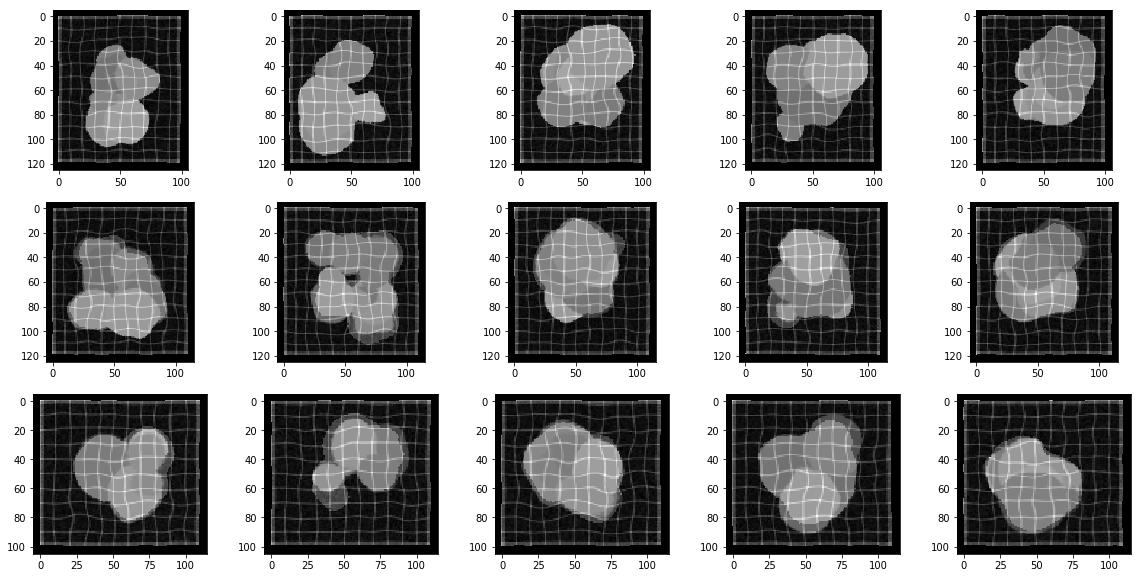

In [3]:
from scipy.ndimage.filters import gaussian_filter

random_state=np.random.RandomState(None)

def deformBothAugmentGaussian(image,mask,defrange=200,sigma=6,margin=10):
    '''
    Deforms the `image' and `mask' input 3D volumes by defining a random deformation field and smoothing it with gaussian_filter(). This is
    faster but produces localized variations which a higher `sigma' value can smooth but at the cost of computation time.
    '''
    inshape=image.shape
    h,w,d =inshape
    
    rmask=np.zeros((h,w,d))
    rmask[margin:-margin,margin:-margin,margin:-margin]=1
    
    rx=random_state.rand(h,w,d) * 2 - 1
    ry=random_state.rand(h,w,d) * 2 - 1
    rz=random_state.rand(h,w,d) * 2 - 1
    
    # instead of defining a small deformation array then resampling it to a larger version, we take a large array and smooth it with a gaussian filter
    imshiftx = gaussian_filter(rx*rmask, sigma, mode="constant", cval=0) * defrange
    imshifty = gaussian_filter(ry*rmask, sigma, mode="constant", cval=0) * defrange
    imshiftz = gaussian_filter(rz*rmask, sigma, mode="constant", cval=0) * defrange
    
    y,x,z= np.meshgrid(np.arange(w), np.arange(h), np.arange(d))
    indices =  np.reshape(x+imshiftx, (-1, 1)), np.reshape(y+imshifty, (-1, 1)),np.reshape(z+imshiftz, (-1, 1))

    distorted_image = map_coordinates(image, indices, order=1, mode='constant')
    distorted_mask =  map_coordinates(mask, indices, order=1, mode='constant')

    return distorted_image.reshape(inshape),distorted_mask.reshape(inshape)

    
testAugment(lambda i,m: deformBothAugmentGaussian(i,m))

625 ms ± 30 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


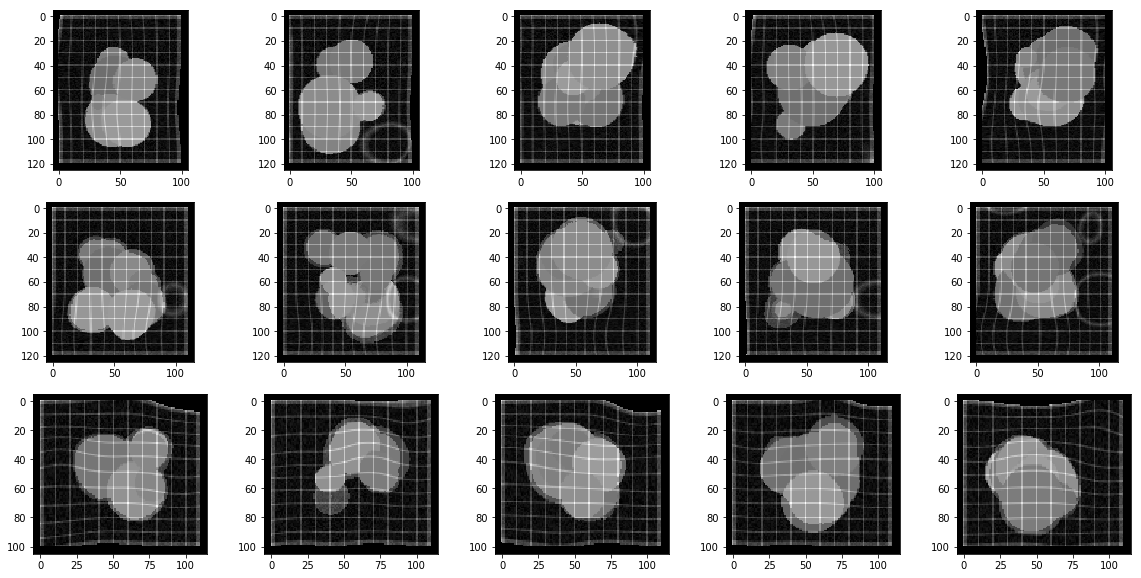

In [4]:
import SimpleITK as sitk
resample = sitk.ResampleImageFilter()

def deformBothAugmentSitk(image,mask,defrange=20,numSplines=4,order=2):
    '''
    Deforms the `image' and `mask' input 3D volumes by using ResampleImageFilter and BSplineTransformInitializer from SimpleITK.
    This is faster but ugly, ideally we'd want the edges fixed but I can't get it to do this.
    '''
    dimension=image.ndim
    numControls=numSplines+order*2

    # start by defining a small 4D volume of deformation values, last dimension is the XYZ vector components
    imshift=np.zeros((3,numControls,numControls,numControls))
    # randomly assign values in the inner portion of the volume, leaving the edges 0
    imshift[:,order:-order,order:-order,order:-order]=np.random.randint(-defrange,defrange,(3,numSplines,numSplines,numSplines))

    im=sitk.GetImageFromArray(image)
    ma=sitk.GetImageFromArray(mask)

    bspline=sitk.BSplineTransformInitializer(im,[numSplines,numSplines,numSplines],order)
    bspline.SetParameters(imshift.flatten())
    resample.SetReferenceImage(im)
    resample.SetInterpolator(sitk.sitkLinear)
    resample.SetDefaultPixelValue(0)
    resample.SetTransform(bspline)
    
    image=sitk.GetArrayFromImage(resample.Execute(im))
    mask=sitk.GetArrayFromImage(resample.Execute(ma))
    
    return image,mask


testAugment(lambda i,m:deformBothAugmentSitk(i,m))